In [1]:
# !pip install -U openmim
# !mim install mmengine
# # !mim install 'mmcv>=2.0.0rc1'
# !mim install 'mmcv==2.0.0rc3'

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
# from sklearn.metrics import jaccard_similarity_score

##　数据下载

这份数据是之前在知乎看到的，放一下链接和下载链接
［知乎链接］（https://zhuanlan.zhihu.com/p/95518858）
［下载链接］（https://link.zhihu.com/?target=https%3A//github.com/akkaze/datasets/raw/master/m2nist.zip）

#＃　数据介绍和EDA

数据主要由三部分构成，分别是
1. `combined.npy` 数字图片
2. `segmented.npy` 掩码图片
3. `bbox.txt` 数字的box位置和数字的值，0-10

In [64]:
data_dir = 'data/m2nist'
X = np.load(f'{data_dir}/combined.npy')
y = np.load(f'{data_dir}/segmented.npy')

SEGMENTATION_TYPE = ['ALL_DIGITS', 'BINARY'][0]
if SEGMENTATION_TYPE == 'BINARY':
    num_classes = 2
    # Collapse per-pixel labels into digit vs non-digit.
    y = np.max(y,axis=3)
    y=np.stack((y==1,y==0),axis=-1)
elif SEGMENTATION_TYPE == 'ALL_DIGITS':
    num_classes = 10

数字图片和掩码图片各自5000张，长宽为64x84

In [69]:
print(X.shape, y.shape)

(5000, 64, 84) (5000, 64, 84)


In [70]:
X = X.astype(np.float32)
y = y.astype(np.float32)

# #Shuffle
# X,y = shuffle(X,y)
#
# # Normalize
# X -= 127.0
# X /= 127.0

In [71]:
np.array(y[1]).min(),np.array(y[1]).max()

(4.0, 10.0)

In [72]:
np.array(X[1]).min(),np.array(X[1]).max(),

(0.0, 255.0)

In [73]:
X[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 数据可视化
随机获取10张图片，分别可视化“数字+掩码”，“数字”，“掩码”
可以看到，每张图中至少有两个数字，但是有点mask中是没有数字的

In [74]:
n = 10
indices = np.random.randint(low=0, high=len(X), size=n)

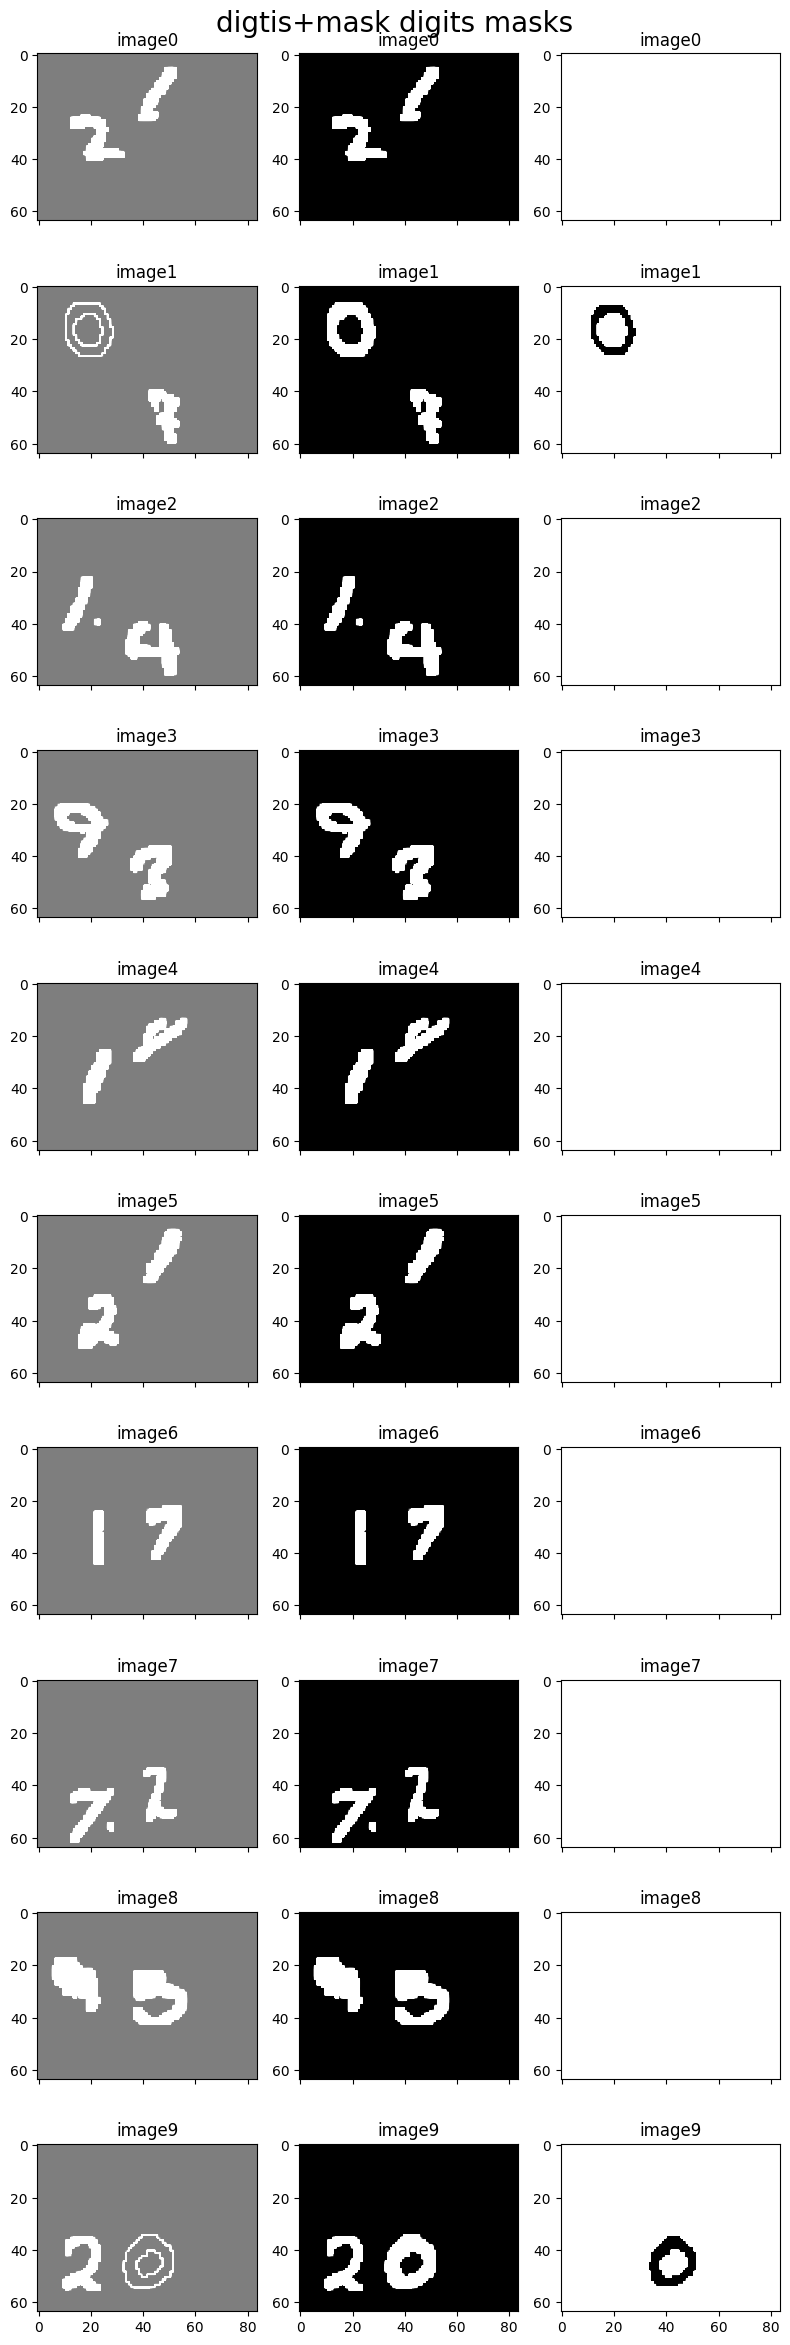

In [75]:
def vis_graph(X,y,n = 10, opacity = 0.5): # 标注区域透明度

    fig, axes = plt.subplots(nrows=n, ncols=3, sharex=True, figsize=(8,12*n/5))
    fig.dpi = 100

    for index, (img, mask) in enumerate(zip(X, y)):
        axes[ index,0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[ index,0].imshow(mask*10, alpha=opacity, cmap='gray', vmin=0, vmax=1)
        axes[ index,0].set_title(f"image{index}")
        axes[ index,1].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[ index,1].set_title(f"image{index}")
        axes[ index,2].imshow(mask*10, cmap='gray', vmin=0, vmax=1)
        axes[ index,2].set_title(f"image{index}")

    fig.suptitle('digtis+mask digits masks', fontsize=20)
    plt.tight_layout()
    plt.show()

vis_graph(X[indices], y[indices])

可以看到，含有0的值，都是有mask的，这个数据集，把掩码用0表示，其他的数字是一些灰色边界值

In [76]:
for i in y[indices]:
    print(np.unique(i))

[ 1.  2. 10.]
[ 0.  7. 10.]
[ 1.  4. 10.]
[ 3.  9. 10.]
[ 1.  8. 10.]
[ 1.  2. 10.]
[ 1.  7. 10.]
[ 2.  7. 10.]
[ 5.  9. 10.]
[ 0.  2. 10.]


## 查看文本数据

In [77]:
count_line = 20
count_ = 0
with open('data/m2nist/bbox.txt','r') as f:
    # print(f.readlines())
    for line in f.readlines():
        line = line.strip('\n')
        print(line)
        count_+=1
        if count_==count_line:
            break

0	12,18,36,40,2	33,27,53,51,9
1	36,19,60,43,4	8,34,32,56,7
2	34,35,56,59,3	2,18,26,42,7
3	10,5,20,29,1	34,20,56,44,6
4	33,27,53,51,4	8,11,27,35,7
5	35,37,57,61,7	7,35,25,59,9
6	20,11,28,35,1	39,9,59,33,3
7	36,38,60,58,0	9,19,23,43,6
8	10,17,27,41,1	32,13,56,37,3
9	6,21,26,45,2	42,3,59,27,4
10	3,2,27,26,0	38,6,62,26,5
11	34,3,58,27,3	4,4,26,28,6
12	18,26,30,50,1	45,15,61,39,6
13	32,36,56,60,3	4,20,28,44,7
14	8,26,24,50,1	39,39,53,63,7
15	35,18,59,42,0	15,13,29,37,1	58,36,82,60,4
16	2,23,26,47,3	37,38,61,62,4
17	32,35,52,59,7	4,15,27,39,9
18	32,11,53,35,1	12,28,33,52,9
19	39,19,60,43,0	8,40,26,63,9


可以发现，每一行都是有行号的，从零开始
每一行，至少有十个数字，最多是15个有效数字，五个数字一组，分别代表着四个角度坐标和数字值
因为我们主要做的事语义分割，这里就不多对该文件探索和使用，但是可以以后作为一个coco格式的数据的



In [78]:
# print(list(line.split(' ').split('\t')))
with open('data/m2nist/bbox.txt','r') as f:
    for line in f.readlines():
        ext = line.strip('\n').replace('\t',' ').split(' ')
        break
ext

['0', '12,18,36,40,2', '33,27,53,51,9']

In [79]:
name_list = []
with open('data/m2nist/bbox.txt','r') as f:
    for line in f.readlines():
        name = ''
        line = line.strip('\n').replace('\t',' ').split(' ')
        for i,v in enumerate(line):
            if i==0:
                name = name+v+'_'
            else:
                name = name+v[-1]+'_'
        name = name[:-1] # name.rstrip('_')
        name_list.append(name)

        # print(name)
        # if line[0]=='15':
        #     break

# 0_2_9
# 1_4_7
# 2_3_7
#
# 13_3_7
# 14_1_7
# 15_0_1_4

In [80]:
len(name_list)  # check, should be 5000

5000



## 划分数据集

In [81]:
import os
import random

In [82]:
#Shuffle
X,y,name_list = shuffle(X,y,name_list)
print(X.shape,y.shape,len(name_list),type(X))

(5000, 64, 84) (5000, 64, 84) 5000 <class 'numpy.ndarray'>


In [83]:
y[1,:,:]

array([[10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       ...,
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.]], dtype=float32)

In [84]:
sel_list = []
for i in range(len(X)):
    if np.any(y[i,:,:]==0):
        sel_list.append(i)
print(len(sel_list))

922


In [85]:
X,y,name_list = X[sel_list,:,:],y[sel_list,:,:],np.array(name_list)[sel_list]
print(X.shape,y.shape,len(name_list))

(922, 64, 84) (922, 64, 84) 922


In [91]:
# 单通道均值
np.mean(X),np.mean(y),np.std(X),np.std(y)

(11.61565, 9.487809, 49.230198, 2.0803504)

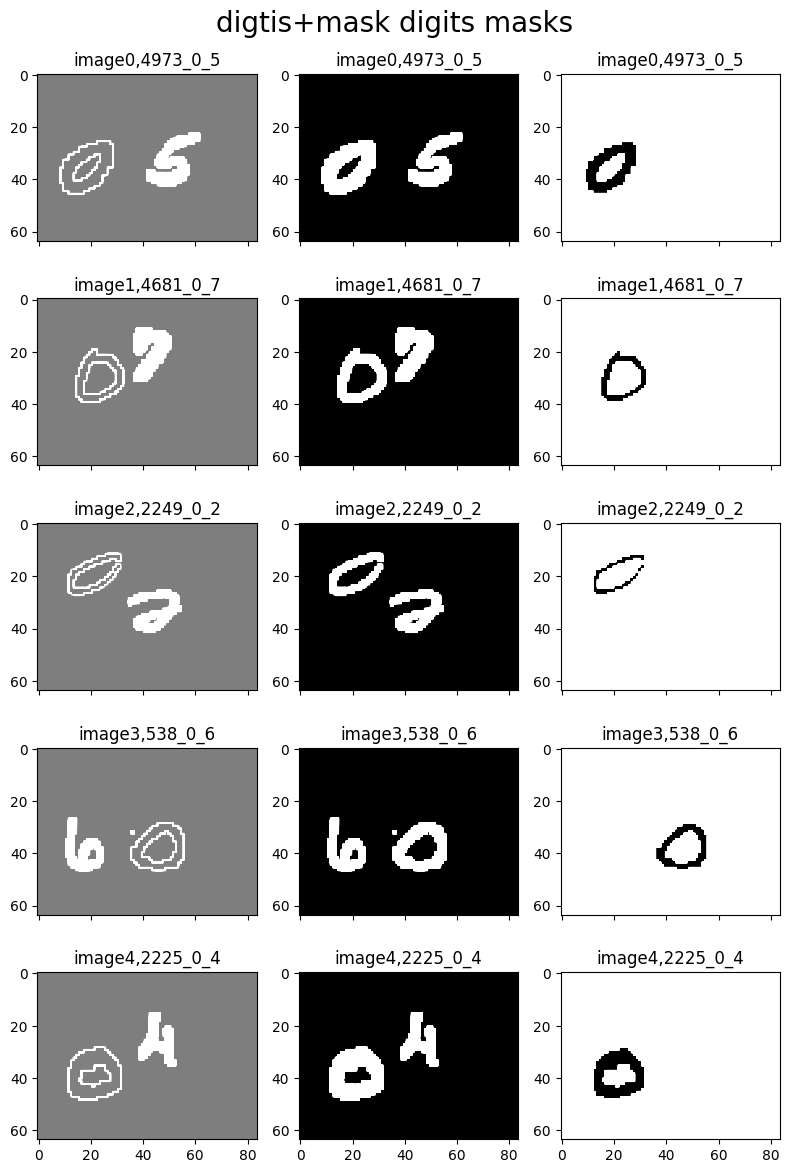

In [21]:
num_show = 5

def vis_graph2(X,y,name_list,n = 10, opacity = 0.5): # 标注区域透明度

    fig, axes = plt.subplots(nrows=n, ncols=3, sharex=True, figsize=(8,12*n/5))
    fig.dpi = 100

    for index, (img, mask,name) in enumerate(zip(X, y,name_list)):
        axes[ index,0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[ index,0].imshow(mask*10, alpha=opacity, cmap='gray', vmin=0, vmax=1)
        axes[ index,0].set_title(f"image{index},{name}")
        axes[ index,1].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[ index,1].set_title(f"image{index},{name}")
        axes[ index,2].imshow(mask*10, cmap='gray', vmin=0, vmax=1)
        axes[ index,2].set_title(f"image{index},{name}")

    fig.suptitle('digtis+mask digits masks', fontsize=20)
    plt.tight_layout()
    plt.show()

vis_graph2(X[:num_show,:,:],y[:num_show,:,:],name_list[:num_show],n=num_show,)

In [22]:
train_ratio = 0.8
test_ratio = 1 - train_ratio
all_file_num = len(X)

In [23]:
train_X, train_y = X[:int(all_file_num*train_ratio)], y[:int(all_file_num*train_ratio)]
test_X, test_y  = X[int(all_file_num*train_ratio):], y[int(all_file_num*train_ratio):]
train_name_list,test_name_list = name_list[:int(all_file_num*train_ratio)], name_list[int(all_file_num*train_ratio):]

print('数据集图像总数', all_file_num)
print('训练集划分比例', train_ratio)
print('训练集图像个数', len(train_X))
print('测试集图像个数', len(test_X))

数据集图像总数 922
训练集划分比例 0.8
训练集图像个数 737
测试集图像个数 185


In [24]:
name_list[0],len(name_list)

('4973_0_5', 922)

In [25]:
train_name_list[:5]

array(['2181_0_2', '41_0_7', '3894_0_6', '3108_0_1', '436_0_3'],
      dtype='<U10')

In [26]:
test_name_list[:5]

array(['1386_0_3', '3919_0_1', '503_0_1', '2137_0_1', '1042_0_0'],
      dtype='<U10')

## 生成两个txt划分文件

In [27]:
with open('data/m2nist/train.txt', 'w') as f:
    f.writelines(line + '\n' for line in train_name_list)
with open('data/m2nist/test.txt', 'w') as f:
    f.writelines(line + '\n' for line in test_name_list)

## 将数据转为图片保存，作为mmseg的标准形式

mask 图片需要进行像素转化，转到0-255

In [28]:
np.array(train_X[1]).min(),np.array(train_X[1]).max(),np.array(train_y[1]).min(),np.array(train_y[1]).max()

(0.0, 255.0, 0.0, 10.0)

In [29]:
np.unique(train_y[1]),np.sum(train_y[1]==0),np.sum(train_y[1]==7), np.sum(train_y[1]==10)

(array([ 0.,  7., 10.], dtype=float32), 156, 179, 5041)

In [30]:
for i in range(10):
    print(np.unique(train_y[i]),np.sum(train_y[i]==0),64*84-np.sum(train_y[i]==0)-np.sum(train_y[i]==10), np.sum(train_y[i]==10))

[ 0.  2. 10.] 221 210 4945
[ 0.  7. 10.] 156 179 5041
[ 0.  6. 10.] 217 192 4967
[ 0.  1. 10.] 135 111 5130
[ 0.  3. 10.] 256 158 4962
[ 0.  8. 10.] 195 238 4943
[ 0.  5. 10.] 143 335 4898
[ 0.  2.  5. 10.] 165 366 4845
[ 0.  3. 10.] 211 185 4980
[ 0. 10.] 397 0 4979


In [31]:
import cv2
from PIL import Image

def save_img(image,path):
    r, b = cv2.threshold(image, 2, 255, cv2.THRESH_BINARY)
    # plt.imshow(b)
    # plt.show()
    Image.fromarray(b.astype(np.uint8)).save(path)


train_mask_path = 'data/m2nist/masks/train/3801_0_1.png'
save_img(train_y[2],train_mask_path)

In [32]:
import cv2
import os
from PIL import Image

data_dir = 'data/m2nist'
PATH_IMAGE = f'{data_dir}/images'
PATH_MASKS = f'{data_dir}/masks'

# #Shuffle
# X,y = shuffle(X,y)
#
# # Normalize
# X -= 127.0
# X /= 127.0

for i in range(len(train_X)):
    train_file_name = train_name_list[i]+'.png'
    train_img_path = os.path.join(PATH_IMAGE, 'train',train_file_name)
    train_mask_path = os.path.join(PATH_MASKS, 'train', train_file_name)
    save_img(train_X[i],train_img_path)
    save_img(train_y[i],train_mask_path)

for i in range(len(test_X)):
    test_file_name = test_name_list[i]+'.png'
    test_img_path = os.path.join(PATH_IMAGE, 'test',test_file_name)
    test_mask_path = os.path.join(PATH_MASKS, 'test', test_file_name)
    save_img(test_X[i],test_img_path)
    save_img(test_y[i],test_mask_path)

In [33]:
train_X.shape,train_name_list.shape

((737, 64, 84), (737,))

In [34]:
!tree data/m2nist

data/m2nist
├── bbox.txt
├── combined.npy
├── images
│   ├── test
│   │   ├── 10_0_5.png
│   │   ├── 1029_0_9.png
│   │   ├── 1031_0_7.png
│   │   ├── 1042_0_0.png
│   │   ├── 1047_0_4.png
│   │   ├── 1050_0_7.png
│   │   ├── 105_0_2.png
│   │   ├── 1057_0_7.png
│   │   ├── 1067_0_5.png
│   │   ├── 1075_0_3.png
│   │   ├── 1083_0_1.png
│   │   ├── 1086_0_6.png
│   │   ├── 1097_0_6.png
│   │   ├── 1100_0_1.png
│   │   ├── 1109_0_1.png
│   │   ├── 1113_0_1.png
│   │   ├── 1143_0_1.png
│   │   ├── 1148_0_1.png
│   │   ├── 1149_0_7.png
│   │   ├── 115_0_2.png
│   │   ├── 1152_0_2.png
│   │   ├── 116_0_4.png
│   │   ├── 1165_0_7.png
│   │   ├── 1177_0_0.png
│   │   ├── 1179_0_5_8.png
│   │   ├── 1198_0_3.png
│   │   ├── 1199_0_0.png
│   │   ├── 1212_0_5.png
│   │   ├── 1218_0_5_8.png
│   │   ├── 1220_0_4.png
│   │   ├── 1224_0_9.png
│   │   ├── 1225_0_7.png
│   │   ├── 1239_0_3.png
│   │   ├── 1242_0_4.png
│   │   ├── 1248_0_4.png
│   │   ├── 125_0_3.png
│   │   ├── 1259_0_9.png
│   │   ├──

## MMSegmentation训练语义分割模型

In [2]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

### palette 颜色设置很重要
#### 检查得知，background为[255,255,255],digits为[0,0,0]

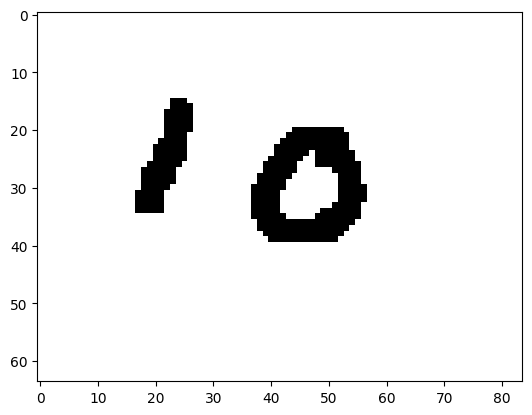

In [3]:
# 单张图像
img_mask = mmcv.imread('data/m2nist/masks/train/15_0_1_4.png')

# mask
plt.imshow(img_mask)
plt.show()

In [27]:
img_mask.shape

(64, 84, 3)

mmcv读取的Mask图片是三通道相同的灰度图片

In [94]:
img_mask[:,:,0]==img_mask[:,:,1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [95]:
np.sum(img_mask[:,:,0]==img_mask[:,:,1])==84*64

True

In [28]:
img_mask[20,48:55,:]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [29]:
sum(sum(img_mask==255)),sum(sum(img_mask==0))

(array([5032, 5032, 5032]), array([344, 344, 344]))

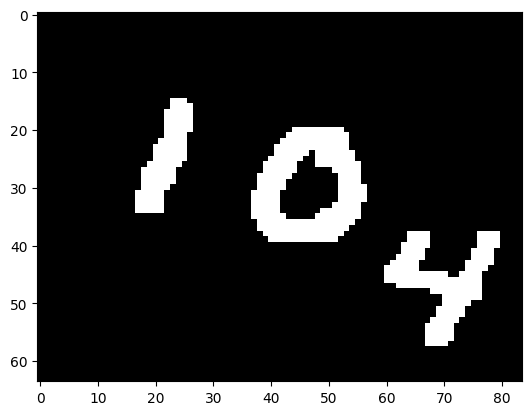

In [30]:
# 单张图像
img = mmcv.imread('data/m2nist/images/train/15_0_1_4.png')

# mask
plt.imshow(img)
plt.show()

In [4]:
# 数据集图片和标注路径
data_root = 'data/m2nist'
img_dir = 'images'
ann_dir = 'masks'

# 类别和对应的颜色
classes = ('background', 'digits')
# palette = [[128, 128, 128], [151, 189, 8]]
palette = [[255,255,255], [[0,0,0]]]
# 检查得知，background为[255,255,255],digits为[0,0,0]

In [37]:
# from mmseg.registry import DATASETS
# from mmseg.datasets import BaseSegDataset
#
# @DATASETS.register_module()
# class M2nistDataset(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [38]:
# !mim search mmsegmentation --model "unet"

--------------------------------------------------------------------------------
config id: unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024
backbone                                                unet-s5-d16
cityscapes/miou                                         69.1
cityscapes/miou(ms+flip)                                71.05
config                                                  configs/unet/unet-s5-...
crop_size                                               (512,1024)
inference_time(ms/im)[V100,PyTorch,1,FP32,(512,1024)]   327.87
lr_schd                                                 160000
model                                                   unet
paper                                                   URL,Title
readme                                                  configs/unet/README.md
training_data                                           cityscapes,drive,star...
training_memory(GB)                                     17.91
weight                                          

In [39]:
# # 下载 config 文件 和 预训练模型checkpoint权重文件
# !mim download mmsegmentation --config unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64 --dest .

processing unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64...
deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth exists in /home/cine/mmsegmentation
Successfully dumped unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64.py to /home/cine/mmsegmentation


In [40]:
# from mmengine import Config
# config_path = "/home/cine/mmsegmentation/configs/unet/unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64.py"
# cfg = Config.fromfile(config_path)
# # cfg = Config.fromfile('unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64.py')
# # cfg = Config.fromfile(config_path)

In [32]:
# # 下载 config 文件 和 预训练模型checkpoint权重文件
# !mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest . --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /home/cine/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /home/cine/mmsegmentation


In [5]:
from mmengine import Config
config_path = "pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py"
cfg = Config.fromfile(config_path)

In [6]:
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
       

In [7]:
cfg.model.auxiliary_head

{'type': 'FCNHead',
 'in_channels': 1024,
 'in_index': 2,
 'channels': 256,
 'num_convs': 1,
 'concat_input': False,
 'dropout_ratio': 0.1,
 'num_classes': 19,
 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True},
 'align_corners': False,
 'loss_decode': {'type': 'CrossEntropyLoss',
  'use_sigmoid': False,
  'loss_weight': 0.4}}

In [13]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.model.data_preprocessor.size = cfg.crop_size  # input size?
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# 修改数据集的 type 和 root
cfg.dataset_type = 'M2nistDataset'
cfg.data_root = data_root #"data/m2nist"

cfg.train_dataloader.batch_size = 8

# remove random resize
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='RandomResize', scale=(84, 64), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

# data_root = 'data/m2nist'
# img_dir = 'images'
# ann_dir = 'masks'
# FileNotFoundError: [Errno 2] No such file or directory: 'data/m2nist/images/4388_0_4.png'
# data/m2nist/images/train


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=f'{img_dir}/train', seg_map_path=f'{ann_dir}/train')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=f'{img_dir}/test/', seg_map_path=f'{ann_dir}/test/')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'test.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = 'deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth'

# 工作目录
cfg.work_dir = './work_dirs/m2nist2'

# 训练迭代次数
cfg.train_cfg.max_iters = 300
# 评估模型间隔
cfg.train_cfg.val_interval = 50
# 日志记录间隔
cfg.default_hooks.logger.interval = 10
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 100

# 随机数种子
cfg['randomness'] = dict(seed=0)


In [14]:
# dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005)
cfg['optimzer'] = dict(type='Adam', lr=0.0001, momentum=0.9, weight_decay=0.0005)

cfg.crop_size = (84, 64)  # crop_size = image size
cfg.model.data_preprocessor.mean = [11.61565,11.61565,11.61565]
cfg.model.data_preprocessor.std = [49.230198,49.230198,49.230198]

In [15]:
print(cfg.pretty_text)


norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[11.61565, 11.61565, 11.61565],
        std=[49.230198, 49.230198, 49.230198],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(84, 64)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
   

In [16]:
cfg.dump('m2nist_cfg.py')

In [98]:
# from mmseg.registry import DATASETS
# from mmseg.datasets import BaseSegDataset
#
# @DATASETS.register_module()
# class M2nistDataset(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

# KeyError: 'M2nistDataset is already registered in dataset at mmseg.datasets.m2nist'

In [17]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules
# from mmseg.datasets import m2nist

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

runner.train()  # FileNotFoundError: [Errno 2]
# No such file or directory: 'data/m2nist/images/1984_0_5_5.png'

/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


02/15 02:48:03 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: False
    numpy_random_seed: 0
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -D

/home/cine/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/cine/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/cine/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/cine/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the s

02/15 02:48:04 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/15 02:48:04 - mmengine - WARNING - The "hook" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:04 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook  

/home/cine/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


02/15 02:48:04 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:04 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:04 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:04 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:04 - mmengine - WARNING - The "optimizer wrapper constructor" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:04 - mmengine - WARNING - The "optimizer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:

/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/evaluator/metric.py:47: UserWarning: The prefix is not set in metric class IoUMetric.
  warnings.warn('The prefix is not set in metric class '


02/15 02:48:05 - mmengine - WARNING - The "weight initializer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/15 02:48:05 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
02/15 02:48:05 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
02/15 02:48:05 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([2, 16, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.bottleneck.conv.weight: copying a param with shape torch.Size([16, 80, 3, 3]) from checkpoint, the shape 

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [18]:
# !python tools/train.py m2nist_cfg.py

In [19]:
# 载入 config 配置文件
from mmengine import Config
from mmengine.runner import Runner
from mmseg.utils import register_all_modules
from mmseg.apis import init_model, inference_model, show_result_pyplot
cfg = Config.fromfile('m2nist_cfg.py')
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/15 03:13:30 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: False
    numpy_random_seed: 0
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -D

AssertionError: class `SegLocalVisualizer` in mmseg/visualization/local_visualizer.py: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not access any other arguments

In [20]:
# 初始化模型
checkpoint_path = './work_dirs/m2nist2/iter_300.pth'
model = init_model(cfg, checkpoint_path, 'cpu')

/home/cine/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/cine/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/cine/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/m2nist2/iter_300.pth


In [97]:
model

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [21]:
# 单张图像
img = mmcv.imread('data/m2nist/images/train/15_0_1_4.png')
mask_img = mmcv.imread('data/m2nist/masks/train/15_0_1_4.png')

In [22]:
result = inference_model(model, img)
result.keys()

['pred_sem_seg', 'seg_logits']

In [23]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
pred_mask.shape

(64, 84)

In [24]:
np.unique(pred_mask)

array([0])

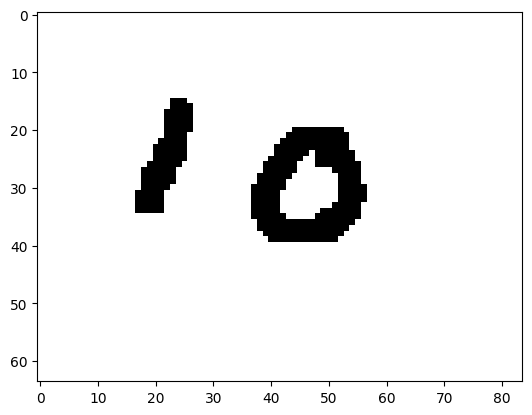

In [25]:
plt.imshow(mask_img)
plt.show()

原图有三个数字，1,0有掩码，

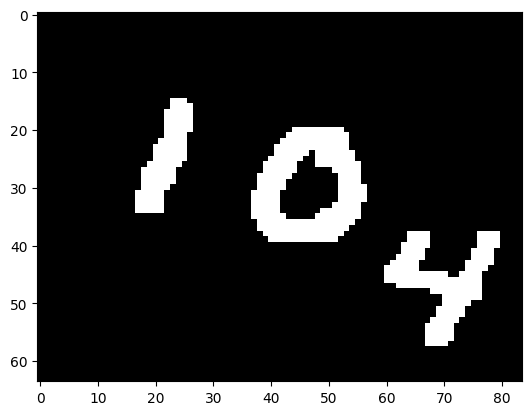

In [26]:
plt.imshow(img)
plt.show()

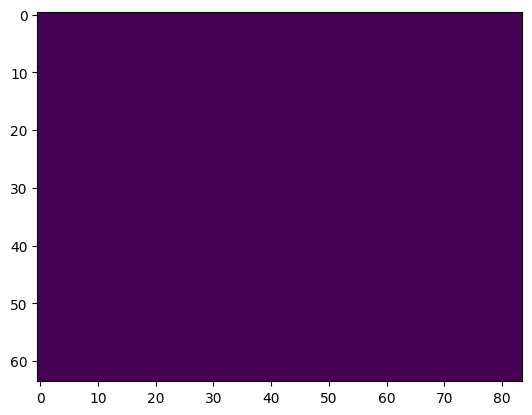

In [28]:
# mask
plt.imshow(pred_mask)
plt.show()

预测结果为全部是背景

/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:163: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


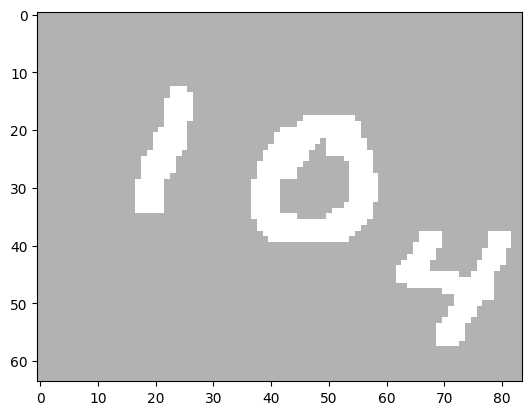

In [30]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

## 预测结果不好就不进行连通域分析了

调整了几次，结果都不好，时间不太够了，后面再慢慢做一下，出问题的原因分析如下

1. crop的部分太小，丢失主体，所以后面取消了crop和resize，但是还是效果不好
2. 可能是resize造成的，模型本来的输入较大，这里输入是84x64的图片，可能最后学到的feature不够，后面再采用resize试试
3. 模型太大，层数太大，训练不够，但是现在loss出现了nan的问题，不太清楚是什么导致的
4. 对于采用的两种模型不够熟悉，后面再尝试用其他模型多多尝试，


# 模型部署

此处实验不理想，时间有限，就搜集一些文档资料吧

1. win10下mmsegmentation的安装训练以及使用mmdeploy部署的全过程_yuanjiaqi_k的博客-CSDN博客

https://blog.csdn.net/yuanjiaqi_k/article/details/126153117


2. 学懂 ONNX，PyTorch 模型部署再也不怕！-阿里云开发者社区

https://developer.aliyun.com/article/914229?spm=a2c6h.13262185.profile.12.68ff5b1f4XaznM

3. MMDeploy部署实战系列【第五章】：Windows下Release x64编译mmdeploy(C++)，对TensorRT模型进行推理 - gy77 - 博客园

https://www.cnblogs.com/gy77/p/16523947.html

4. 记录mmdeploy部署fastscnn到ncnn并量化 - 知乎

https://zhuanlan.zhihu.com/p/567319765

In [ ]:
# 联通域分析
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

In [ ]:
# 用整数表示每个连通域区域
connected[1].shape

In [ ]:
np.unique(connected[1])

In [ ]:
plt.imshow(connected[1])
plt.show()

In [ ]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

In [ ]:
# 每个连通域的质心坐标
connected[3]

In [ ]:
# 获取测试集标注
label = mmcv.imread('Glomeruli-dataset/masks/VUHSK_1702_39.png')
label_mask = label[:,:,0]
label_mask.shape

In [ ]:
np.unique(label_mask)

In [ ]:
plt.imshow(label_mask)
plt.show()

In [ ]:
# 测试集标注
label_mask.shape

In [ ]:
# 语义分割预测结果
pred_mask.shape

In [ ]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [ ]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [ ]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [ ]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

In [ ]:
plt.imshow(TP)
plt.show()

In [ ]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10


In [ ]:
plt.imshow(confusion_map)
plt.show()

In [ ]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix_model = confusion_matrix(label_map.flatten(), pred_mask.flatten())

In [ ]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))

    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)

    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [ ]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

# 模型部署

此处实验不理想，时间有限，就搜集一些文档资料吧

win10下mmsegmentation的安装训练以及使用mmdeploy部署的全过程_yuanjiaqi_k的博客-CSDN博客

https://blog.csdn.net/yuanjiaqi_k/article/details/126153117


学懂 ONNX，PyTorch 模型部署再也不怕！-阿里云开发者社区

https://developer.aliyun.com/article/914229?spm=a2c6h.13262185.profile.12.68ff5b1f4XaznM

MMDeploy部署实战系列【第五章】：Windows下Release x64编译mmdeploy(C++)，对TensorRT模型进行推理 - gy77 - 博客园

https://www.cnblogs.com/gy77/p/16523947.html

记录mmdeploy部署fastscnn到ncnn并量化 - 知乎

https://zhuanlan.zhihu.com/p/567319765